# No show appointments Investigation

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information
from 100k medical appointments in
Brazil and is focused on the question
of whether or not patients show up
for their appointment. A number of
characteristics about the patient are
included in each row.
#### Questions:
 What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?<br>
What is the precentage of patients who miss there appointment?<br>

In [4]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# including magic word so visualization are plotted inline
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [5]:
# loading the csv file
df = pd.read_csv('data/noshowappointments-kagglev2-may-2016.csv')
# printing with head function to make sure things work
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


first let us check how big our dataset is?

In [6]:
df.shape

(110527, 14)

Our dataset has 110527 rows and 14 columns.<br>

next cell we will take a look inside our dataset with info function


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Info function gave us a lot of useful informations.first the whole dataset doesn't have any null objects in it.
We have many types of data types like float64, int64 and object(which is string).

### Delete patients who are over 100 years old

Patients who are over 100 years old are really specile case. We need to delete them from our dataset to avoid rare cases.<br>
let's see how many patients who are older than 100 years.

In [8]:
# using query function to select patient who are older that 100 years 
df.query('Age > 100')['PatientId'].count()

7

Only 7 patients from total of 110527 

In [9]:
# using query function to select patients under 100 years old to be only exsist in the dataset
df = df.query('Age <= 100')

### Changing the naming format of the columns to be underscore style

Let's print the columns names to see which columns need to be changed

In [10]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

There is only one column need to be change which is "No-show" column.

In [11]:
# using rename function to change the colomn "No-show" to "No_show"
df = df.rename(columns = {'No-show':'No_show'})

### Editing "No_show" column

As we saw earlier the column "No_show" has to possible value which are Yes or No.<br>
Changing the value to be 1 instead of Yes and 0 instead of No will be useful when we explore the data

In [12]:
# creating function that return 1 if value is Yes or return 0 in value is No
def text_to_int(value):
    if value == 'No':
        return 0
    return 1
# using apply function to work with "No_show" column
df['No_show'] = df['No_show'].apply(text_to_int)

### Editing "AppointmentDay" column's data type

We saw earlier that "AppointmentDay" column has string data type.<br>
It is hard to manipulate the dates with string data type.A better choice to change the data type to datatime64.

In [13]:
# using to_datetime function to change the type to datatime
df['AppointmentDay'] = pd.to_datetime(df.AppointmentDay)
# checking the correction
df.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay              object
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hipertension               int64
Diabetes                   int64
Alcoholism                 int64
Handcap                    int64
SMS_received               int64
No_show                    int64
dtype: object

### Adding columns to help us in our exploration

One of the strength of Pandas that has groupby function.To use this function with dates we need to create columns for year, month and day of week.<br>
But first we need to see for how long this dataset has been collecting data?

In [14]:
# using min and max function to see the earliest and latest date 
df.AppointmentDay.min() , df.AppointmentDay.max()

(Timestamp('2016-04-29 00:00:00'), Timestamp('2016-06-08 00:00:00'))

As we can see the dataset is collection the data from 2016-04-29 to 2016-06-08.<br>
This data is collected for 48 days.This will not be useful to work with years or even month.<br>
Let's create new column to hold day of week values.

In [15]:
# using day_name functionj to get the name of day 
df['day_of_week'] = df.AppointmentDay.dt.day_name()

<a id='eda'></a>
## Exploratory Data Analysis

### What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

In [16]:
# using groupby function to explore the data
df_grouped = df.groupby('No_show')
# using agg functoin to see the difference between patient who show up and who didn't
df_grouped.agg(np.mean)

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
No_show,,,,,,,,,
0,1.476713e+14,5.681135e+06,37.786858,0.093907,0.204390,0.07384,0.030418,0.022731,0.291336
1,1.467677e+14,5.652258e+06,34.306820,0.115522,0.169027,0.06408,0.030337,0.020165,0.438430


From the above information it is abvois that the average age of patients who show up is 37.79 and the average age of patients who didn't is 34.31 .<br>
Let us visualize our findings.

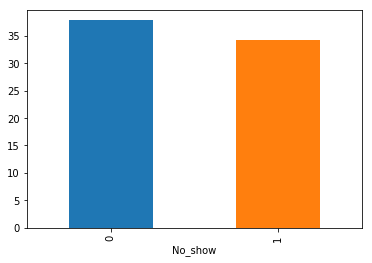

In [17]:
# using plot function to plot the average age between Patient who show up and who didn't
df_grouped['Age'].agg(np.mean).plot(kind='bar');

Another angle we can see our data from is day of week.<br>
Let us plot the data.

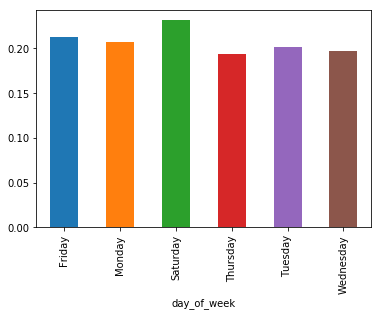

In [18]:
#using groupby and mean function to get the average No show of "day_of_week" column then plot to visualize it.
df.groupby('day_of_week')['No_show'].mean().plot(kind='bar');

It is abvois that Saturday has the highest patients who didn't show up.<br>
But wait let us see the data size of each day of week.

In [19]:
# using  groupby and size functions to see the distribution of data among days of week
df.groupby('day_of_week').size()

day_of_week
Friday       19018
Monday       22713
Saturday        39
Thursday     17244
Tuesday      25639
Wednesday    25867
dtype: int64

ooops!!<br>
Saturday has only 39 patients.In this case we can't rely on this data.<br>
Friday and monday have the highest precentage of patients who didn't show up.<br>
So the important factors are the Age and day of week.<br>
let's see the number of males and females in each day of week.

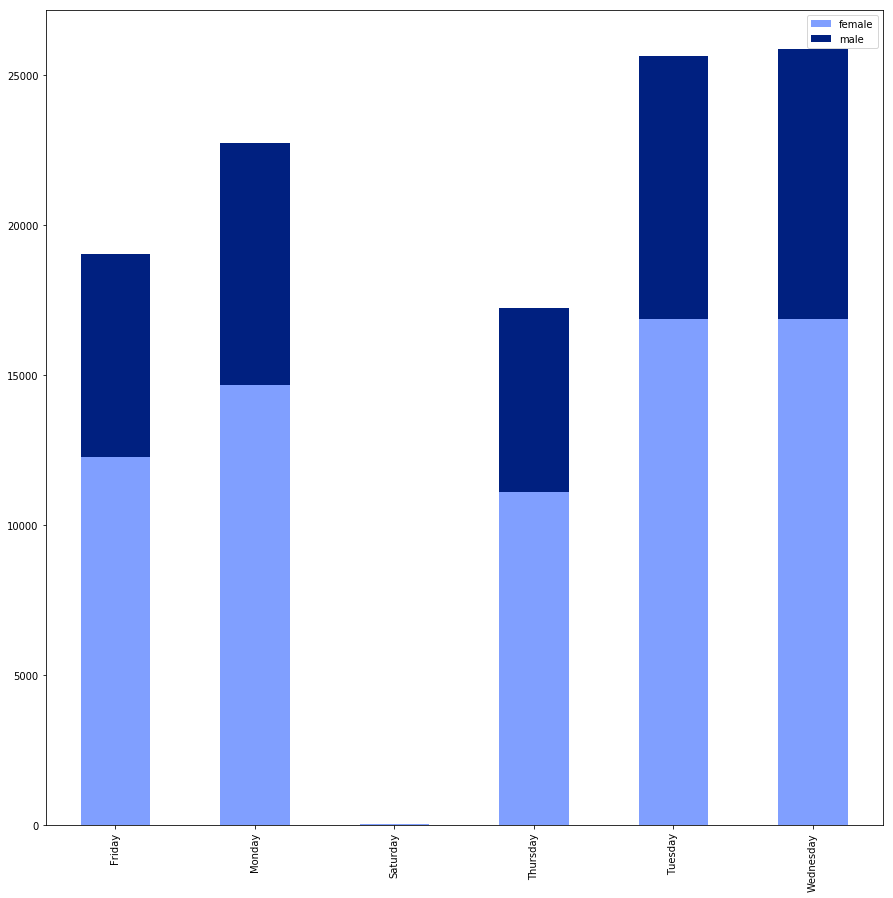

In [20]:
# let's prepare for new dataframe
# following statments for creating rows of the dataframe
day_of_week = ['Friday','Monday','Saturday','Thursday','Tuesday','Wednesday']
female_list = df.query('Gender == "F"').groupby('day_of_week').size().tolist()
male_list = df.query('Gender == "M"').groupby('day_of_week').size().tolist()

#using list and zip function to create iterable variable
rows= list(zip( day_of_week, female_list, male_list))

# names of the columns
headers = ['DOW','female','male']

# using DataFrame function to create the dataframe, choosing headers to be the columns and 
# day_of_week to be the index
df_days = pd.DataFrame(rows, columns=headers,index=day_of_week)

# picking colors for the bar graph
colors = ["#809fff", "#002080"]

#creating stacked bar graph with size of (15,15)
df_days.plot.bar(stacked=True, color=colors, figsize=(15,15));

It is clearly that females more than male in all days.

### What is the precentage of patients who miss there appointment ?

One of useful graph is pie graph.Remeber when we changed our "No_show" column values to 0 and 1.This make it easier to investigate the column.

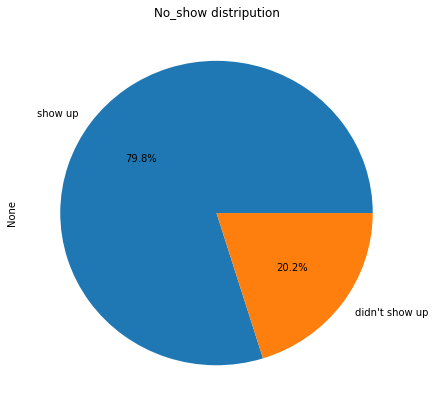

In [21]:
# using plot function to visualize pie graph
df.groupby('No_show').size().plot.pie(title='No_show distripution', labels=['show up',"didn't show up"], figsize=(7,7), autopct='%1.1f%%');

<a id='conclusions'></a>
## Conclusions
The dataset has been collected for 40 days.The dataset is not enough to investigate in many angles like investigation for a long period of time like years or even months.One of difficulties I faced that most of colmns are boolean based valued for this I could't apply 2D charts in the angle I wanted. 
After all,The average age of patients who show up is 37.79 and the average age of patients who didn't is 34.31 .And we found that friday and monday have the highest precentage of patients who didn't show up.<br>
The data shows that 20.2% of patients miss there appointments.